# Stock Crawler

Stock is a good way to get rich, but you will get burned if you don't know any information about it. In this notebook, you will learn how to get stock data from websites and process it. Let's become a stock master. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import re
import math
import datetime
import requests
import itertools
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

## Stock Trading Volume, Price

The stock data source of this part is https://goodinfo.tw/tw2/StockList.asp.  
When requesting, it needs headers.

In [2]:
url = 'https://goodinfo.tw/tw2/StockList.asp'

# get it from inspect
# headers = {
# 'User-Agent': *****
# 'Cookie':  *****
# }

headers = {
'User-Agent':'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Mobile Safari/537.36',
'Cookie':'CLIENT%5FID=20241011134431707%5F36%2E224%2E208%2E130; CLIENT%5FID=20241011134431707%5F36%2E224%2E208%2E130; IS_TOUCH_DEVICE=F; _ga=GA1.1.1755936400.1728625476; _cc_id=e6d6d76cdb5d34e764ebdad115933b1; panoramaId_expiry=1729230276158; panoramaId=334a83255af6a3e3079e8afcbe2816d53938ab0205c267620057fd9630b26dc9; panoramaIdType=panoIndiv; cto_bundle=yWSavV9jMXI3cTBLUkkxRFJidGhYSUpLaGl5ZU9La0V1QXhpbnRabThQS040V0l3cVJ1cktMbmFmMmVzamtkTiUyQjhydXNLZEQzOHpXQVMwNGVaWkdMTTk4S1N4VyUyQjB2Qm85RVhiaUtpTzZwcVJ0Qk9xJTJCRmFrc3BGMThTYmtEJTJCQVp3RFhBb1ZET1Vpd3o2T0NsNXNuV21WTmNDaDA5Vll6VVBhNFZSZiUyQnVoeDNQaklGdDVIWGNaeU93RVhmdlhheiUyRkoxOWZab3VxRlNRdDFjd05SUGRxVDBsSWpQYmtGVHFvYVZtQUkwJTJGZXBOMjdMTzBzbWY4UXR4cFJzWUVxY3BMQ0JXeEZETXFhY3JOQXRxWkJGalFOOGFlVUF0bmVQS2ZWRDZXdm4lMkJtV0Q4c0pyV0hpRCUyRkN0JTJCTnRhNndkMzdrbE5ueHQlMkZHM1FKaVViM1N3a3QwbjQzemJaVmxDU1BKUEFrQ2tEUDY4eDJtVTlGTms0JTNE; TW_STOCK_BROWSE_LIST=8032%7C3529; _ga_0LP5MLQS7E=GS1.1.1728651867.3.1.1728653590.52.0.0; SCREEN_SIZE=WIDTH=679&HEIGHT=871'
}

Here are the requested parameters of the stock trading volume, and price.    
If you want to get another table, observe the payload on your own.

In [3]:
volume_params = {
'SEARCH_WORD':'',
'SHEET': '交易狀況',
'SHEET2': '近12日成交量一覽',
'RPT_TIME': '最新資料',
'MARKET_CAT': '熱門排行',
'INDUSTRY_CAT': '成交張數 (高→低)@@成交張數@@由高→低',
'STOCK_CODE': '',
'SORT_FIELD': '',
'SORT': '',
'STEP': 'DATA',
'RANK': '0'
}

price_params = {
'SEARCH_WORD':'',
'SHEET': '交易狀況',
'SHEET2': '近12日收盤價一覽',
'RPT_TIME': '最新資料',
'MARKET_CAT': '熱門排行',
'INDUSTRY_CAT': '成交張數 (高→低)@@成交張數@@由高→低',
'STOCK_CODE': '',
'SORT_FIELD': '',
'SORT': '',
'STEP': 'DATA',
'RANK': '0'
}

Here is the requested function.   
If there is a duplicated stock No. which has been crawled, stop the function. 

In [4]:
def get_stock(req_params):
    stock = pd.DataFrame()
    stock_list = []
    for i in range(0, 100):
        try:
            req_params['RANK'] = str(i)
            res = requests.get(url, headers=headers, params=req_params)
            res.encoding= 'utf-8'
            soup = BeautifulSoup(res.text, 'html')
            data = soup.find_all("div", {"class": "b1 r10 box_shadow"})
            tmp = pd.read_html(data[0].prettify())[0]
            new_stock_list = tmp['名稱'].to_list()
            if new_stock_list[-1] in stock_list:
                break
            stock_list += new_stock_list
            stock = pd.concat([stock, tmp])
            time.sleep(3)
        except:
            break
    stock = stock.loc[stock['代號'] != '代號']
    stock = stock.reset_index(drop=True)
    return stock

### Stock Volume

In [5]:
df_volume = get_stock(volume_params)
df_volume

,排 名,代號,名稱,10/14 成交量 (張),10/15 成交量 (張),10/16 成交量 (張),10/17 成交量 (張),10/18 成交量 (張),10/21 成交量 (張),10/22 成交量 (張),10/23 成交量 (張),10/24 成交量 (張),10/25 成交量 (張),10/28 成交量 (張),10/29 成交量 (張),10/29 收盤價
0,1,00632R,元大台灣50反1,101805,178498,189803,76298,322620,84417,76629,81401,87960,51112,103845,240310,3.31
1,2,00919,群益台灣精選高息,40635,46104,58821,32055,43910,37454,29314,37102,48499,22217,41469,145910,23.31
2,3,00929,復華台灣科技優息,53707,82660,56309,43349,76749,68549,63972,52046,71221,34274,50455,143409,18.62
3,4,00637L,元大滬深300正2,263898,142264,203028,154059,205300,191449,110966,121640,109099,93372,113732,92628,16.31
4,5,00878,國泰永續高股息,27422,39094,41233,26571,52040,32977,27361,41975,42662,21691,34618,92465,22.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2192,5205,中茂,0,0,4,3,0,2,5,4,0,16,2,0,37.85
2192,2193,5348,正能量智能,10,7,10,8,8,11,8,6,3,9,10,0,25.3
2193,2194,6236,中湛,8,4,4,3,0,0,8,0,12,0,3,0,29
2194,2195,8472,夠麻吉,5,10,12,17,19,19,10,2,6,10,1,0,26.2


### Stock Price

In [6]:
df_price = get_stock(price_params)
df_price

,排 名,代號,名稱,10/14 收盤價,10/15 收盤價,10/16 收盤價,10/17 收盤價,10/18 收盤價,10/21 收盤價,10/22 收盤價,10/23 收盤價,10/24 收盤價,10/25 收盤價,10/28 收盤價,10/29 收盤價
0,1,00632R,元大台灣50反1,3.29,3.24,3.28,3.27,3.21,3.22,3.21,3.24,3.26,3.24,3.25,3.31
1,2,00919,群益台灣精選高息,23.46,23.6,23.59,23.74,23.73,23.83,23.84,23.82,23.7,23.74,23.7,23.31
2,3,00929,復華台灣科技優息,18.89,19.06,19.05,19.12,19.11,19.17,19.04,18.98,18.86,18.9,18.87,18.62
3,4,00637L,元大滬深300正2,17.61,16.93,16.3,16.12,16.41,16.48,16.67,17.02,16.46,16.7,16.41,16.31
4,5,00878,國泰永續高股息,22.78,23.01,22.89,23.04,23.12,23.11,23.18,23.07,22.98,23.1,23.13,22.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2192,5205,中茂,39,39,39,39,39,39,40,39.5,39.5,38.25,37.85,37.85
2192,2193,5348,正能量智能,26.45,26.85,26.3,26.5,26.5,26.5,25.95,26.25,24.3,24.3,25.3,25.3
2193,2194,6236,中湛,29.95,29.95,29.95,29.95,29.95,29.95,32.1,32.1,30,30,29,29
2194,2195,8472,夠麻吉,27.75,26.95,26.55,26.4,26.6,26.3,25.8,26.7,26.3,26.8,26.2,26.2


Prepare the `trading_date` for the subsequent usage.

In [7]:
trading_date = [str(datetime.datetime.today().year) + '/' + i.split(' ')[0] for i in df_price.columns[3:]]
trading_date

['2024/10/14',
 '2024/10/15',
 '2024/10/16',
 '2024/10/17',
 '2024/10/18',
 '2024/10/21',
 '2024/10/22',
 '2024/10/23',
 '2024/10/24',
 '2024/10/25',
 '2024/10/28',
 '2024/10/29']

Rename the columns

In [8]:
df_volume.columns = ['stock_rank', 'stock_no', 'stock_name'] + [f'volume{i}' for i in range(12, 0, -1)] + ['price']
df_volume[[f'volume{i}' for i in range(12, 0, -1)]] = df_volume[[f'volume{i}' for i in range(12, 0, -1)]].fillna('0').astype('int')
df_volume = df_volume.drop_duplicates('stock_no')
df_volume

,stock_rank,stock_no,stock_name,volume12,volume11,volume10,volume9,volume8,volume7,volume6,volume5,volume4,volume3,volume2,volume1,price
0,1,00632R,元大台灣50反1,101805,178498,189803,76298,322620,84417,76629,81401,87960,51112,103845,240310,3.31
1,2,00919,群益台灣精選高息,40635,46104,58821,32055,43910,37454,29314,37102,48499,22217,41469,145910,23.31
2,3,00929,復華台灣科技優息,53707,82660,56309,43349,76749,68549,63972,52046,71221,34274,50455,143409,18.62
3,4,00637L,元大滬深300正2,263898,142264,203028,154059,205300,191449,110966,121640,109099,93372,113732,92628,16.31
4,5,00878,國泰永續高股息,27422,39094,41233,26571,52040,32977,27361,41975,42662,21691,34618,92465,22.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2192,5205,中茂,0,0,4,3,0,2,5,4,0,16,2,0,37.85
2192,2193,5348,正能量智能,10,7,10,8,8,11,8,6,3,9,10,0,25.3
2193,2194,6236,中湛,8,4,4,3,0,0,8,0,12,0,3,0,29
2194,2195,8472,夠麻吉,5,10,12,17,19,19,10,2,6,10,1,0,26.2


In [9]:
df_price.columns = ['stock_rank', 'stock_no', 'stock_name'] + [f'price{i}' for i in range(12, 0, -1)]
df_price[[f'price{i}' for i in range(12, 0, -1)]] = df_price[[f'price{i}' for i in range(12, 0, -1)]].fillna('0').astype('float')
df_price = df_price.drop_duplicates('stock_no')
df_price

,stock_rank,stock_no,stock_name,price12,price11,price10,price9,price8,price7,price6,price5,price4,price3,price2,price1
0,1,00632R,元大台灣50反1,3.29,3.24,3.28,3.27,3.21,3.22,3.21,3.24,3.26,3.24,3.25,3.31
1,2,00919,群益台灣精選高息,23.46,23.60,23.59,23.74,23.73,23.83,23.84,23.82,23.70,23.74,23.70,23.31
2,3,00929,復華台灣科技優息,18.89,19.06,19.05,19.12,19.11,19.17,19.04,18.98,18.86,18.90,18.87,18.62
3,4,00637L,元大滬深300正2,17.61,16.93,16.30,16.12,16.41,16.48,16.67,17.02,16.46,16.70,16.41,16.31
4,5,00878,國泰永續高股息,22.78,23.01,22.89,23.04,23.12,23.11,23.18,23.07,22.98,23.10,23.13,22.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2192,5205,中茂,39.00,39.00,39.00,39.00,39.00,39.00,40.00,39.50,39.50,38.25,37.85,37.85
2192,2193,5348,正能量智能,26.45,26.85,26.30,26.50,26.50,26.50,25.95,26.25,24.30,24.30,25.30,25.30
2193,2194,6236,中湛,29.95,29.95,29.95,29.95,29.95,29.95,32.10,32.10,30.00,30.00,29.00,29.00
2194,2195,8472,夠麻吉,27.75,26.95,26.55,26.40,26.60,26.30,25.80,26.70,26.30,26.80,26.20,26.20


## Stock financing, investor

Foreign investors are already rich, but they are greedy to be richer. Paying attention to their actions could get useful information.   
Financing can let us know what is the trend foreseeing of the stock in others' minds.
There are two data sources:  
1.https://www.twse.com.tw/ is for 上市 stocks.  
2.https://www.tpex.org.tw/ is for 上櫃 stocks.

Before we get started, prepare the date parameters.

In [10]:
trading_date1  = [''.join(i.split('/')) for i in trading_date]
taiwan_year = str(datetime.datetime.today().year - 1911)
trading_date2 = [taiwan_year + i[4:] for i in trading_date]
print(trading_date1)
print(trading_date2)

['20241014', '20241015', '20241016', '20241017', '20241018', '20241021', '20241022', '20241023', '20241024', '20241025', '20241028', '20241029']
['113/10/14', '113/10/15', '113/10/16', '113/10/17', '113/10/18', '113/10/21', '113/10/22', '113/10/23', '113/10/24', '113/10/25', '113/10/28', '113/10/29']


### Foreign Investor

In [11]:
investor = pd.DataFrame()
date_order = len(trading_date1)
for i in trading_date1:
    tmp_investor = pd.read_html(f'https://www.twse.com.tw/rwd/zh/fund/T86?date={i}&selectType=ALL&response=html')[0]
    tmp_investor.columns = tmp_investor.columns.droplevel(0)
    tmp_investor['日期'] = date_order
    date_order -= 1
    investor = pd.concat([investor, tmp_investor])
    time.sleep(3)
investor = investor[['證券代號', '證券名稱', '外陸資買賣超股數(不含外資自營商)', '投信買賣超股數', '自營商買賣超股數','三大法人買賣超股數', '日期']]
investor.columns = ['stock_no', 'stock_name', '外資', '投信', '自營商', '三大法人總計', '日期']
investor[['外資', '投信', '自營商', '三大法人總計']] = investor[['外資', '投信', '自營商', '三大法人總計']] / 1000
investor

,stock_no,stock_name,外資,投信,自營商,三大法人總計,日期
0,00882,中信中國高股息,19744.900,0.00,15909.669,35654.569,12
1,00940,元大台灣價值高息,17707.300,0.00,11641.674,29348.974,12
2,2888,新光金,23825.000,0.00,-1397.000,22428.000,12
3,00929,復華台灣科技優息,14025.498,0.00,3993.863,18019.361,12
4,2891,中信金,11960.802,4217.25,1171.855,17349.907,12
...,...,...,...,...,...,...,...
13724,0056,元大高股息,-7373.045,200.00,-57174.611,-64347.656,1
13725,00878,國泰永續高股息,-13567.414,0.00,-56052.986,-69620.400,1
13726,00715L,期街口布蘭特正2,-1410.000,0.00,-72530.040,-73940.040,1
13727,00929,復華台灣科技優息,-48141.872,0.00,-52498.426,-100640.298,1


In [12]:
investor2 = pd.DataFrame()
date_order = len(trading_date2)
for i in trading_date2:
    tmp_investor2 = pd.read_html(f'https://www.tpex.org.tw/web/stock/3insti/daily_trade/3itrade_hedge_result.php?l=zh-tw&o=htm&se=AL&t=D&d={i}&s=0,asc')[0]
    tmp_investor2.columns = tmp_investor2.columns.get_level_values(1) + tmp_investor2.columns.get_level_values(2)
    tmp_investor2 = tmp_investor2.loc[:len(tmp_investor2)-2,]
    tmp_investor2['日期'] = date_order
    date_order -= 1
    investor2 = pd.concat([investor2, tmp_investor2])
    time.sleep(3)
investor2 = investor2[['代號代號', '名稱名稱', '外資及陸資買賣超股數', '投信買賣超股數', '自營商買賣超股數', '三大法人買賣超 股數合計三大法人買賣超 股數合計', '日期']]
investor2.columns = ['stock_no', 'stock_name', '外資', '投信', '自營商', '三大法人總計', '日期']
investor2[['外資', '投信', '自營商', '三大法人總計']] = investor2[['外資', '投信', '自營商', '三大法人總計']].astype('float') / 1000
investor2

,stock_no,stock_name,外資,投信,自營商,三大法人總計,日期
0,NaN,NaN,NaN,NaN,NaN,NaN,12
1,00679B,元大美債20年,1759.85,0.0,-33824.763,-32064.913,12
2,00687B,國泰20年美債,-5229.56,0.0,-23392.210,-28621.770,12
3,00694B,富邦美債1-3,1.00,0.0,5.895,6.895,12
4,00695B,富邦美債7-10,-1.00,0.0,-65.000,-66.000,12
...,...,...,...,...,...,...,...
4537,725956,雙鴻群益46購01,0.00,0.0,0.000,0.000,1
4538,725963,鈊象凱基44購12,0.00,0.0,0.000,0.000,1
4539,725966,福裕凱基44購01,0.00,0.0,-10.000,-10.000,1
4540,725968,元債20國票44購01,0.00,0.0,-1.000,-1.000,1


In [13]:
df_investor = pd.concat([investor, investor2]).reset_index(drop=True)
df_investor

,stock_no,stock_name,外資,投信,自營商,三大法人總計,日期
0,00882,中信中國高股息,19744.900,0.00,15909.669,35654.569,12
1,00940,元大台灣價值高息,17707.300,0.00,11641.674,29348.974,12
2,2888,新光金,23825.000,0.00,-1397.000,22428.000,12
3,00929,復華台灣科技優息,14025.498,0.00,3993.863,18019.361,12
4,2891,中信金,11960.802,4217.25,1171.855,17349.907,12
...,...,...,...,...,...,...,...
238487,725956,雙鴻群益46購01,0.000,0.00,0.000,0.000,1
238488,725963,鈊象凱基44購12,0.000,0.00,0.000,0.000,1
238489,725966,福裕凱基44購01,0.000,0.00,-10.000,-10.000,1
238490,725968,元債20國票44購01,0.000,0.00,-1.000,-1.000,1


## Stock Financing

In [14]:
financing = pd.DataFrame()
date_order = len(trading_date1)
for i in trading_date1:
    tmp_financing = pd.read_html(f'https://www.twse.com.tw/rwd/zh/marginTrading/MI_MARGN?date={i}&selectType=ALL&response=html')[1]
    tmp_financing.columns = tmp_financing.columns.get_level_values(1) + tmp_financing.columns.get_level_values(2)
    tmp_financing['日期'] = date_order
    date_order -= 1
    financing = pd.concat([financing, tmp_financing])
    time.sleep(3)
financing = financing[['股票代號', '股票名稱', '融資買進', '融資賣出', '融資現金償還', '融資前日餘額', '融資今日餘額',
       '融券買進', '融券賣出', '融券現券償還', '融券前日餘額', '融券今日餘額', '日期']]

In [15]:
financing2 = pd.DataFrame()
date_order = len(trading_date2)
for i in trading_date2:
    tmp_financing2 = pd.read_html(f'https://www.tpex.org.tw/www/zh-tw/margin/balance?date={i}&id=&response=html')[0]
    tmp_financing2.columns = tmp_financing2.columns.get_level_values(1) + tmp_financing2.columns.get_level_values(2)
    tmp_financing2 = tmp_financing2.loc[:len(tmp_financing2) - 4,]
    tmp_financing2['日期'] = date_order
    date_order -= 1
    financing2 = pd.concat([financing2, tmp_financing2])
    time.sleep(3)
financing2 = financing2[['代號代號', '名稱名稱', '融資資買', '融資資賣', '融資現償', '融資前資 餘額(張)', '融資資餘額',
    '融券券賣', '融券券買', '融券券償', '融券前券 餘額(張)', '融券券餘額', '日期']]
financing2.columns = ['股票代號', '股票名稱', '融資買進', '融資賣出', '融資現金償還', '融資前日餘額', '融資今日餘額', '融券買進', '融券賣出', '融券現券償還', '融券前日餘額', '融券今日餘額', '日期']

In [16]:
financing = pd.concat([financing, financing2])
financing = financing.rename(columns={'股票代號':'stock_no', '股票名稱':'stock_name'})
financing

,stock_no,stock_name,融資買進,融資賣出,融資現金償還,融資前日餘額,融資今日餘額,融券買進,融券賣出,融券現券償還,融券前日餘額,融券今日餘額,日期
0,0050,元大台灣50,48,138,0,1119,1029,4,2,0,233,231,12
1,0051,元大中型100,0,0,0,0,0,0,0,0,0,0,12
2,0052,富邦科技,12,0,0,293,305,0,0,0,4,4,12
3,0053,元大電子,0,0,0,0,0,0,0,0,0,0,12
4,0055,元大MSCI金融,0,0,0,57,57,0,0,0,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,9949,琉園,0,0,0,0,0,0,0,0,0,0,1
795,9950,萬國通,0,0,0,0,0,0,0,0,0,0,1
796,9951,皇田,1,0,0,415,416,0,0,0,11,11,1
797,9960,邁達康,0,0,0,113,113,0,0,0,0,0,1


## Analysis and Make Money

Now you have to do Explore Data Analysis on your own.  
You can get insights and draw a graph like this: 

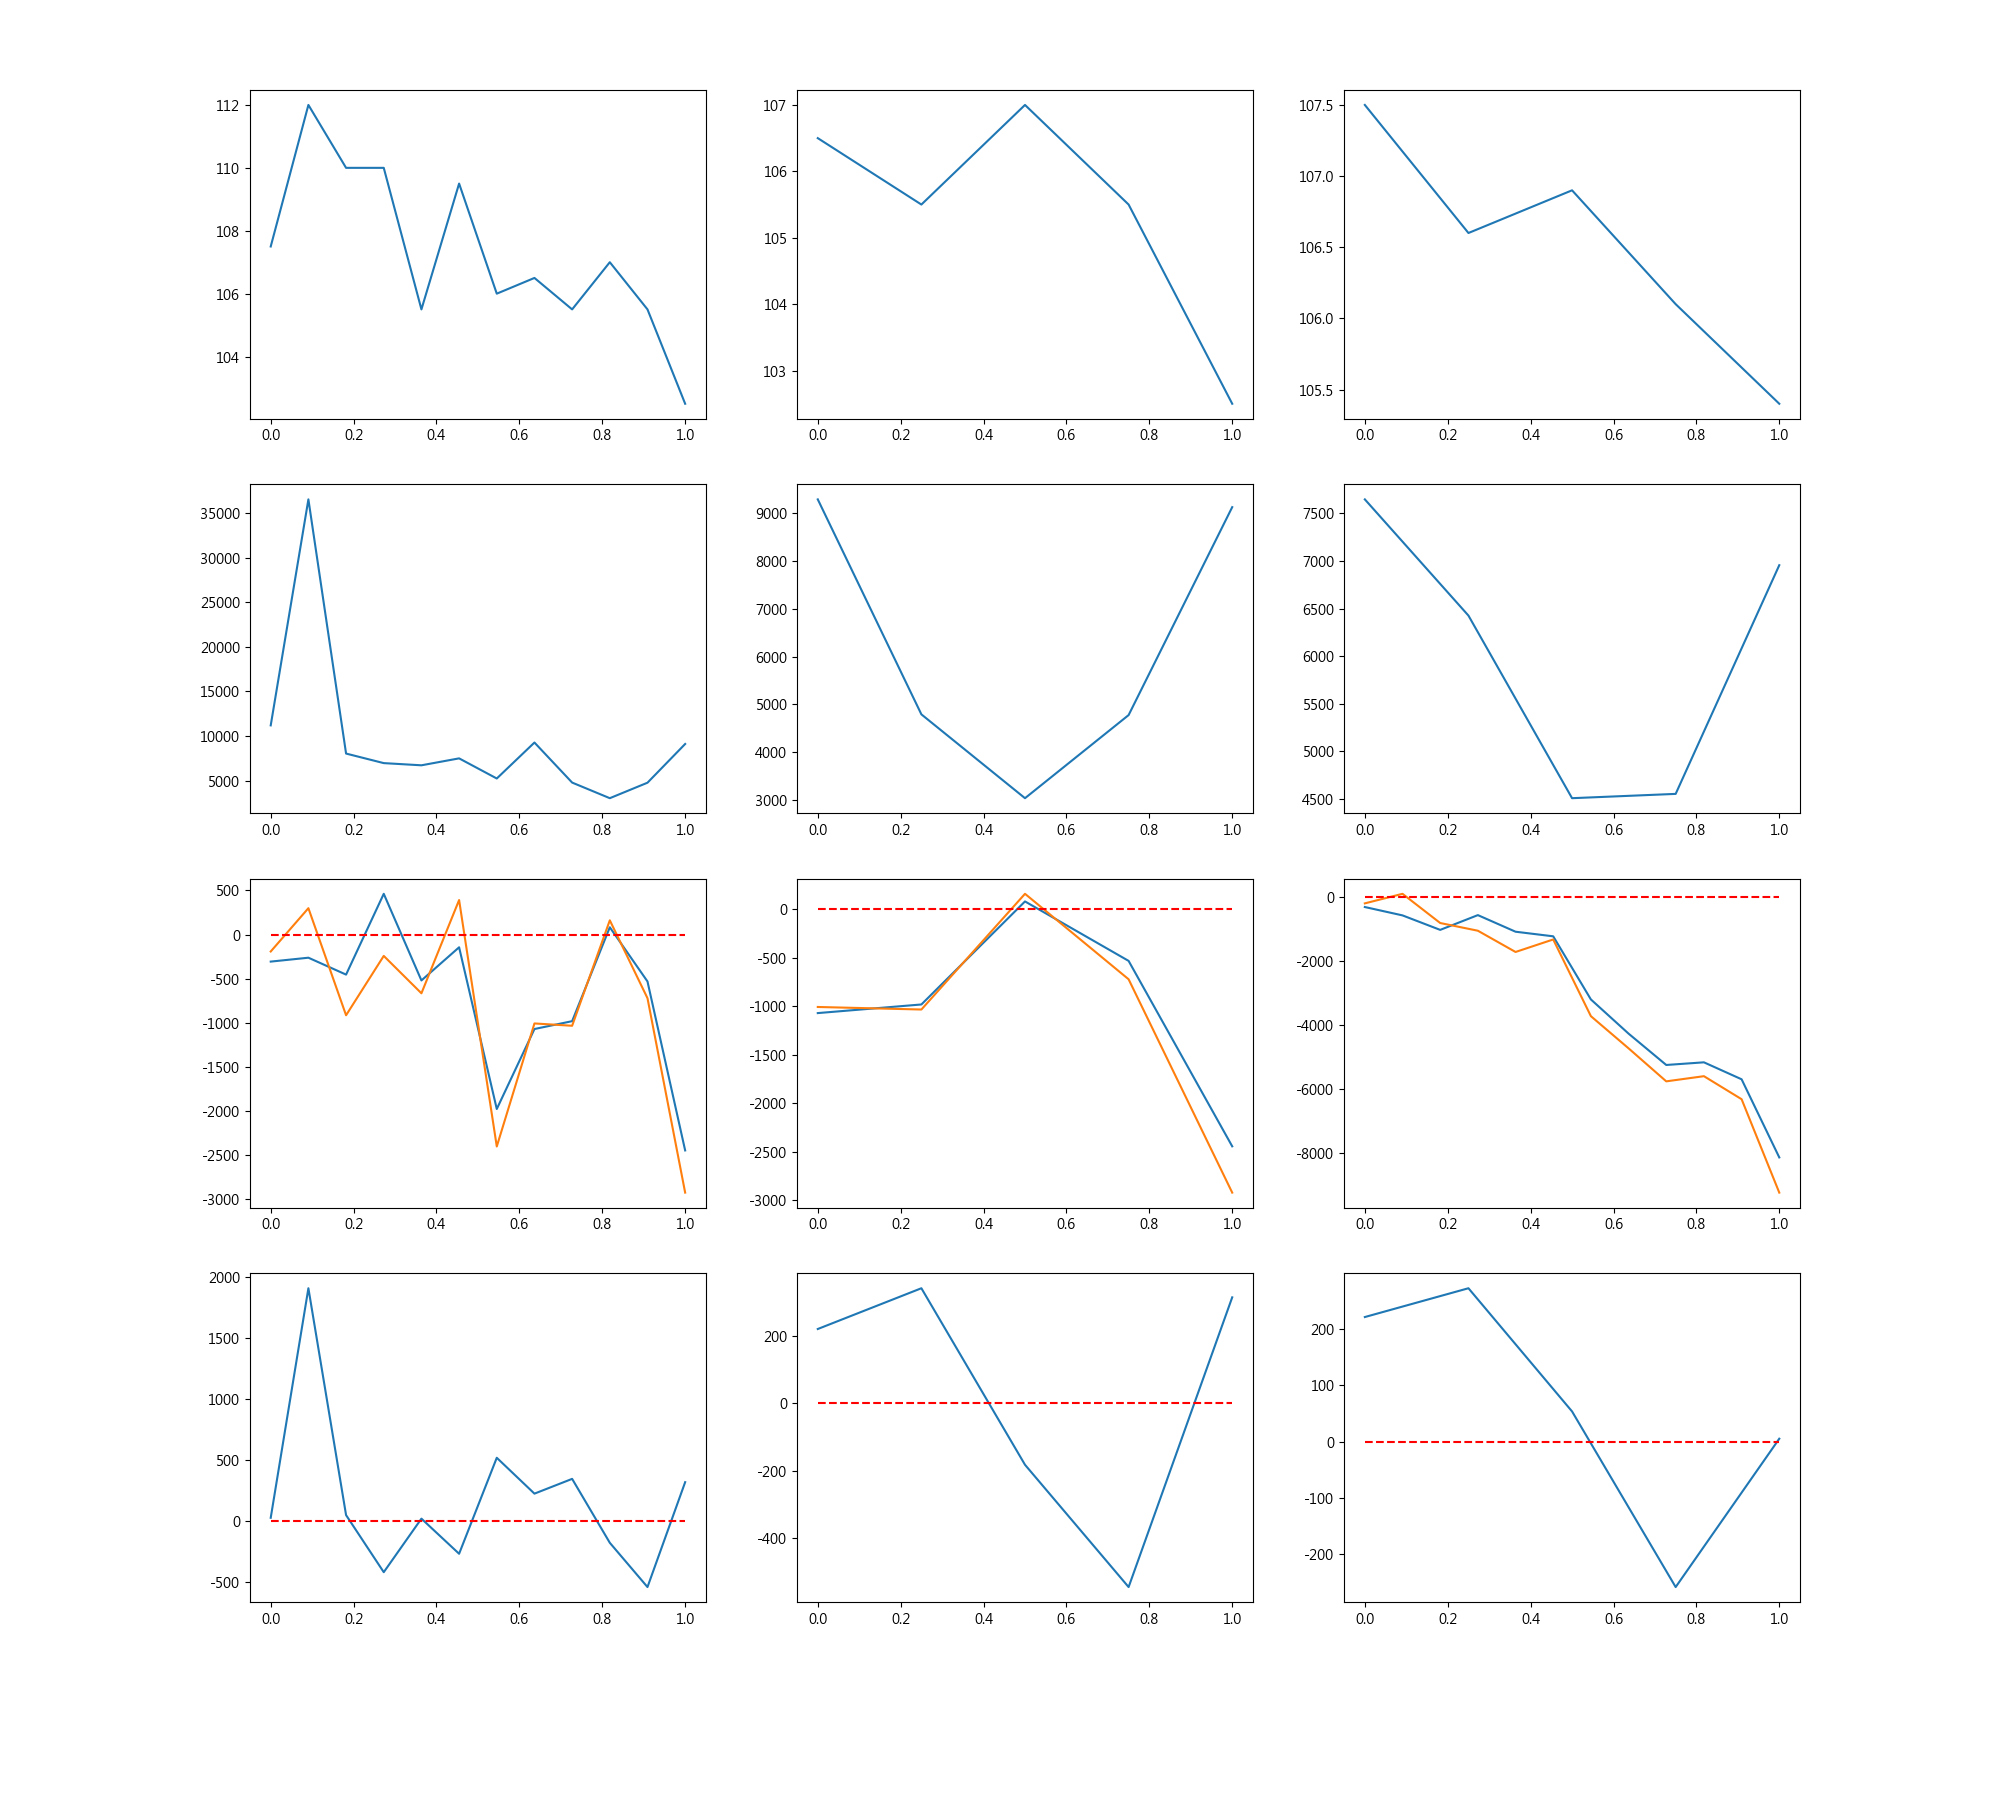

**Hope your stocks make great gains! Good luck!**